# 伊藤くんの卒研：ツイート-ハッシュタグ間のリンク予測
ポイントは以下のとおり：
1. ツイートを BERT により埋め込む → ツイートノードの特徴ベクトルとする。
1. ハッシュタグは，番号を振るだけ。（特徴ベクトルを持たない）
1. 畳み込み層へ「二部グラフに対応できるモデル」を持ってくる (e.g. SAGEConv は OK / GCNConv は NG)
1. ROC-AUC により評価する。

コードの元ネタは以下のとおり：
- Heterogeneous Graphでグラフニューラルネットワークの学習をやってみた (2022.12.20)
- https://engineers.ntt.com/entry/2022/12/20/084912

In [1]:
# 必要なライブラリのインポート
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Module

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.nn import GraphConv, SAGEConv, ResGatedGraphConv, TransformerConv, to_hetero
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader

In [2]:
# データ読み込み
import pickle

# データの置き場所
PARENT_DIR = "../Data_Olympic_7/"

# データの読み込み（pandas）
# ツイートデータを df_text.pkl から／ハッシュタグのデータを movies.pkl から読み込む
#df_recipes = pd.read_csv('./data/food/recipes.csv')
#df_reviews = pd.read_csv('./data/food/reviews.csv')
with open(PARENT_DIR + 'df_text.pkl', 'rb') as f: # tweet
    df_tweet = pickle.load(f)
with open(PARENT_DIR + 'movies.pkl', 'rb') as f: # tag
    df_hashtag = pickle.load(f)

# データ準備
#df_reviews = df_reviews[df_reviews.RecipeId.isin(df_recipes["RecipeId"].unique())]  # 不要データ除外
#df_recipes['RecipeServings'] = df_recipes['RecipeServings'].fillna(df_recipes['RecipeServings'].median())   # 欠損値補完

# ハッシュタグノードとツイートノードのIDマップ作成
# (メモ) df_text.pkl / movies.pkl の時点で「重複なしの連番が振られている」ため
#        ここまで面倒なことをしなくてよい。しかし，元コードを殺さないよう，
#        無理矢理，合わせている。
unique_hashtag_id = df_hashtag["movie_id"].unique()
unique_hashtag_id = pd.DataFrame(
    data={
        "hashtag_id": unique_hashtag_id,
        "mappedID": pd.RangeIndex(len(unique_hashtag_id)),
    }
)

unique_tweet_id = df_tweet["text_id"].unique()
unique_tweet_id = pd.DataFrame(
    data={
        "tweet_id": unique_tweet_id,
        "mappedID": pd.RangeIndex(len(unique_tweet_id)),
    }
)
'''
review_user_id = pd.merge(
    df_reviews["AuthorId"],
    unique_user_id,
    left_on="AuthorId",
    right_on="user_id",
    how="left",
)
review_recipe_id = pd.merge(
    df_reviews["RecipeId"],
    unique_recipe_id,
    left_on="RecipeId",
    right_on="recipe_id",
    how="left",
)
'''

review_hashtag_id = unique_hashtag_id.copy()
review_tweet_id = unique_tweet_id.copy()

# ハッシュタグIDとツイートIDのエッジ情報をTensorへ変換
# (メモ) 元コードではこの時点でエッジ情報を生成しているが，
#        卒研では ratings.pkl にエッジ情報が格納されているから，読み込むだけで OK
'''
tensor_review_user_id = torch.from_numpy(review_user_id["mappedID"].values)
tensor_review_recipe_id = torch.from_numpy(review_recipe_id["mappedID"].values)
tensor_edge_index_user_to_recipe = torch.stack(
    [tensor_review_user_id, tensor_review_recipe_id],
    dim=0,
)
'''

with open(PARENT_DIR + "ratings.pkl", "rb") as f:
    df = pickle.load(f)
tensor_review_hashtag_id = torch.from_numpy(df['movie_id'].values) # ハッシュタグ
tensor_review_tweet_id = torch.from_numpy(df['user_id'].values) # ツイート
tensor_edge_index_hashtag_to_tweet = torch.stack(
    [tensor_review_hashtag_id, tensor_review_tweet_id],
    dim=0,
)
    
# (メモ)
# これ以降，review_hashtag_id / review_tweet_id は使用されない


In [3]:
# (確認) ハッシュタグ ID が正確に振られているか，確認
# (メモ) これ以降は mappedID の列が使用される
review_hashtag_id

,hashtag_id,mappedID
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
212,212,212
213,213,213
214,214,214
215,215,215


In [3]:
# (確認) ツイート ID が正確に振られているか，確認
# (メモ) これ以降は mappedID の列が使用される
review_tweet_id

,tweet_id,mappedID
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
86116,86116,86116
86117,86117,86117
86118,86118,86118
86119,86119,86119


In [4]:
# (確認) エッジ情報の確認
print(tensor_edge_index_hashtag_to_tweet)
print("Number of edge:", len(tensor_edge_index_hashtag_to_tweet[0]))

tensor([[    0,     1,     2,  ...,    95,     4,    76],
        [    0,     0,     0,  ..., 86118, 86119, 86120]])
Number of edge: 113967


In [5]:
# tweetノードの特徴量定義
# (メモ) 別プログラムにおいて，ツイートの埋め込み(e.g. BERT embedding) を
#        行っているため，ここでは読み込むだけである。
'''
recipe_feature_cols = [
    "Calories", "FatContent", "SaturatedFatContent",
    "CholesterolContent", "SodiumContent", "CarbohydrateContent",
    "FiberContent", "SugarContent", "ProteinContent",
    "RecipeServings",
]
df_recipes_feature = pd.merge(df_recipes, unique_recipe_id, left_on='RecipeId', right_on='recipe_id', how='left')
df_recipes_feature = df_recipes_feature.sort_values('mappedID').set_index('mappedID')
df_recipes_feature = df_recipes_feature[df_recipes_feature.index.notnull()]
df_recipes_feature = df_recipes_feature[recipe_feature_cols]

# 標準化
scaler = StandardScaler()
scaler.fit(df_recipes_feature)
scaler.transform(df_recipes_feature)
df_recipes_feature = pd.DataFrame(scaler.transform(df_recipes_feature), columns=df_recipes_feature.columns)

# レシピノードの特徴量をTensorへ変換
tensor_recipes_feature = torch.from_numpy(df_recipes_feature.values).to(torch.float)
'''
text_vectors = np.load(PARENT_DIR + 'tweet_vector.npy')
tensor_tweet_feature = torch.from_numpy(text_vectors).to(torch.float)

In [6]:
# データローダの定義

# HeteroDataオブジェクトの作成
data = HeteroData()
data['hashtag'].node_id = torch.arange(len(unique_hashtag_id))
data['tweet'].node_id = torch.arange(len(unique_tweet_id))
data['tweet'].x = tensor_tweet_feature
data['hashtag', 'review', 'tweet'].edge_index = tensor_edge_index_hashtag_to_tweet
data = T.ToUndirected()(data)

# 学習・評価用のデータ分割
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1, 
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2,
    add_negative_train_samples=False,
    edge_types=("hashtag", "review", "tweet"),
    rev_edge_types=("tweet", "rev_review", "hashtag"), 
)
train_data, val_data, test_data=transform(data)

BATCH_SIZE = 64 #256

# 学習用データローダー定義
edge_label_index = train_data["hashtag", "review", "tweet"].edge_label_index
edge_label = train_data["hashtag", "review", "tweet"].edge_label
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2,
    edge_label_index=(("hashtag", "review", "tweet"), edge_label_index),
    edge_label=edge_label,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# 検証用データローダー定義
edge_label_index = val_data["hashtag", "review", "tweet"].edge_label_index
edge_label = val_data["hashtag", "review", "tweet"].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("hashtag", "review", "tweet"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * BATCH_SIZE,
    shuffle=False,
)

In [7]:
# (確認) グラフを構成するデータの確認
data

HeteroData(
  hashtag={ node_id=[217] },
  tweet={
    node_id=[86121],
    x=[86121, 768]
  },
  (hashtag, review, tweet)={ edge_index=[2, 113967] },
  (tweet, rev_review, hashtag)={ edge_index=[2, 113967] }
)

In [8]:
# モデルの定義
# (2023.01.23 メモ) とりあえず SAGEConv / GraphConv / ResGatedGRaphConv / TransformerConv を引っ張ってくる。
class GNN(Module):
    def __init__(self, hidden_channels: int):
        super().__init__()
        # SAGEConv
        '''
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        '''

        # GraphConv
        '''
        self.conv1 = GraphConv(hidden_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        '''

        # ResGatedGraphConv
        '''
        self.conv1 = ResGatedGraphConv(hidden_channels, hidden_channels)
        self.conv2 = ResGatedGraphConv(hidden_channels, hidden_channels)
        '''

        # TransformerConv
        self.conv1 = TransformerConv(hidden_channels, hidden_channels)
        self.conv2 = TransformerConv(hidden_channels, hidden_channels)
        
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class Classifier(Module):
    def forward(
        self, x_hashtag: Tensor, x_tweet: Tensor, edge_label_index: Tensor
    ) -> Tensor:
        edge_feat_hashtag = x_hashtag[edge_label_index[0]]
        edge_feat_tweet = x_tweet[edge_label_index[1]]

        return (edge_feat_hashtag * edge_feat_tweet).sum(dim=-1)


class Model(Module):
    def __init__(self, hidden_channels: int):
        super().__init__()
        # self.recipe_lin = torch.nn.Linear(10, hidden_channels)
        self.tweet_lin = torch.nn.Linear(768, hidden_channels)
        self.hashtag_emb = torch.nn.Embedding(data["hashtag"].num_nodes, hidden_channels)
        self.tweet_emb = torch.nn.Embedding(data["tweet"].num_nodes, hidden_channels)
        self.gnn = GNN(hidden_channels)
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
            "hashtag": self.hashtag_emb(data["hashtag"].node_id),
            "tweet": self.tweet_lin(data["tweet"].x) + self.tweet_emb(data["tweet"].node_id),
        }

        x_dict = self.gnn(x_dict, data.edge_index_dict)

        pred = self.classifier(
            x_dict["hashtag"],
            x_dict["tweet"],
            data["hashtag", "review", "tweet"].edge_label_index,
        )

        return pred

100%|█████████████████████████████████████████| 428/428 [00:44<00:00,  9.69it/s]


Epoch: 0001, Loss: -4106280616492296.5000


100%|█████████████████████████████████████████| 428/428 [00:44<00:00,  9.72it/s]


Epoch: 0002, Loss: -1127132438074624640.0000


100%|█████████████████████████████████████████| 428/428 [00:44<00:00,  9.71it/s]


Epoch: 0003, Loss: -8539846168410007552.0000


100%|█████████████████████████████████████████| 428/428 [00:44<00:00,  9.67it/s]


Epoch: 0004, Loss: -42506692613156175872.0000


100%|█████████████████████████████████████████| 428/428 [00:44<00:00,  9.64it/s]


Epoch: 0005, Loss: -135412605137693409280.0000


100%|█████████████████████████████████████████| 179/179 [00:04<00:00, 44.28it/s]


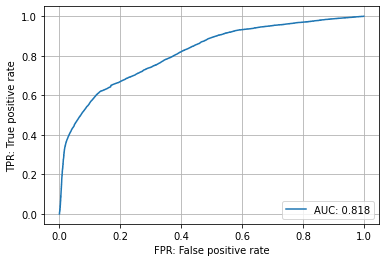

In [9]:
# 学習と評価 (with ROC-AUC)
def train(model, loader, device, optimizer, epoch):
    model.train()
    for epoch in range(1, epoch):
        total_loss = total_samples = 0
        for batch_data in tqdm(loader):
            optimizer.zero_grad()
            batch_data = batch_data.to(device)
            pred = model(batch_data)
            loss = F.binary_cross_entropy_with_logits(
                pred, batch_data["hashtag", "review", "tweet"].edge_label
            )
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * pred.numel()
            total_samples += pred.numel()
        print(f"Epoch: {epoch:04d}, Loss: {total_loss / total_samples:.4f}")

def validation(model, loader, device, optimizer):
    y_preds = []
    y_trues = []
    model.eval()
    for batch_data in tqdm(loader):
        with torch.no_grad():
            batch_data = batch_data.to(device)
            pred = model(batch_data)
            y_preds.append(pred)
            y_trues.append(batch_data["hashtag", "review", "tweet"].edge_label)

    y_pred = torch.cat(y_preds, dim=0).cpu().numpy()
    y_true = torch.cat(y_trues, dim=0).cpu().numpy()
    auc = roc_auc_score(y_true, y_pred)
    return auc, y_pred, y_true


# パラメータの設定
model = Model(hidden_channels=768)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

# 学習・評価
train(model, train_loader, device, optimizer, 6)
auc, y_pred, y_true = validation(model, val_loader, device, optimizer)

# 精度確認（ROC-AUC曲線）
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, label=f"AUC: {auc:.3f}")
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.legend(loc='lower right')
plt.grid()

---
## 以下は結果を可視化する試み (未完成)
mappedID により管理されているノードを，元のツイート／ハッシュタグへ戻し，その中身をチェックする。

(TODO) 偽陽性となったエッジ（に繋がるノード）を可視化するコードは未了

In [10]:
val_data["hashtag", "review", "tweet"].edge_label # 長さ 7209

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [11]:
val_data["hashtag", "review", "tweet"].edge_label_index

tensor([[    0,    80,   110,  ...,    10,    68,    76],
        [64743, 45556, 33751,  ..., 22905, 51661, 69544]])

In [12]:
val_edge_label_index = val_data["hashtag", "review", "tweet"].edge_label_index
len(val_edge_label_index[0])

34188

In [14]:
for idx in range(10):
    print("=============")
    a_hashtag = val_edge_label_index[0][idx].cpu().numpy() # user (tag)
    a_tweet = val_edge_label_index[1][idx].cpu().numpy() # recipie (tweet)
    target_hashtag = df_hashtag[df_hashtag['movie_id']==a_hashtag]
    target_tweet = df_tweet[df_tweet['text_id']==a_tweet]
    print(target_hashtag['title'].values[0])
    print(target_tweet['original_text'].values[0])

#卓球
いいぞ水谷いとう！！！！      #卓球
#スケートボード
日本の堀米がオリンピックのスケートボードで金メダル！！      #スケートボード
#阿部詩
すげえ！阿部兄妹！見てへんけど！←   #柔道 #阿部詩 #阿部一二三
#柔道
おめでとう！！　#大野将平  #柔道　
#オリンピック開催して良かった
#オリンピック開催して良かった  1997世代の五輪が東京で開催される奇跡！！   そしてNo.10を我らの堂安が付けている！！！ GKはU23から成長を見届けてきた谷晃生！ めちゃくちゃ嬉しい！！！
#伊藤美誠
水谷選手、伊藤選手、金メダル獲得おめでとうございます！ 最後まで緊張感に包まれた試合、自宅から必死に旗を振って応援しました！ お疲れ様でした！！  #水谷準  #伊藤美誠     #水谷伊藤ペア  #卓球 #卓球混合    
#阿部一二三
兄妹揃ってオリンピックの決勝戦に進んだ家族とか親族ってどんな気分なんだ？全く他人でももう緊張感ハンパなくなってきた笑 #柔道  #阿部詩 #阿部一二三 
#
# 東京五輪とか東京オリンピックって付ければツイートを見てくれる確率が増えるのか、、、
#卓球
卓球混合ダブルス決勝戦は仕事中やから観れんな😢⤵️⤵️  残念ヽ(;´ω｀)ﾉ   #卓球 #混合ダブルス
#フジテレビ
球体開いた！！  キレイな炎🔥❤️‍🔥  #フジテレビ   
